In [73]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [74]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph 
from langgraph.graph import START, END

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import pretty_print_messages
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI

In [75]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, 'dummy']

In [76]:
######### 2. 도구 정의 및 바인딩 #########

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:     # 키워드로 뉴스 검색하는 도구     
    """Look up news by keyword"""

    news_tool = GoogleNews()        
    return news_tool.search_by_keyword(query, k=2)


tools = [search_keyword]

In [77]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [78]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')
    
    return {
        'messages': [answer], 
        'dummy_data': '[chatbot] 호출, dummy_data'
    }

In [79]:
# 상태 그래프 생성
graph_builder = StateGraph(State)

In [80]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [81]:
# 도구 노드 생성
tool_node = ToolNode(tools=[search_keyword])

In [82]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [83]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [84]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [85]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [86]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [87]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [88]:

graph = graph_builder.compile(checkpointer=memory)

In [89]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

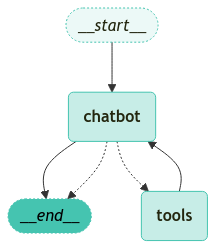

In [90]:
######### 8. 그래프 #######

visualize_graph(graph)

In [91]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

In [92]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

i = 1

for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    print(f'({i})')
    print('=== 반복문 바같 === 시작')
    for key, value in event.items():
        print('=== 반복문 === 시작')
        print(f'\n[노드 이름]: {key}\n')                    # key 에는 노드의 이름
        # print(f"\n해당 노드의 값[value]: \n{value['messages'][-1]}")            

        if value['messages'][-1] is not None:
            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"해당 노드의 값 [value][messages][-1]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값
                print('==================== END HumanMessage ====================')
                print() 
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"해당 노드의 값 [value]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값
                print('==================== END AIMessage ====================')     
                print()       
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"해당 노드의 값 [value]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값
                print(f'Tool Calls:')
                print(f"\t name: {value['messages'][-1].name}")
                print(f"\t tool_call_id: {value['messages'][-1].tool_call_id}")
                print('==================== END ToolMessage ====================')     
                print()       
        else:
            print(f"해당 노드의 값 [value]: 없음")
            print()

        print('=== 반복문 === 끝')
    print('=== 반복문 바같 === 끝\n\n')
    i=i+1

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}
(1)
=== 반복문 바같 === 시작
=== 반복문 === 시작

[노드 이름]: chatbot

==================== AIMessage ========================
해당 노드의 값 [value]: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_det

In [93]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

i = 1

for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    print(f'({i})')
    print('=== 반복문 바같 === 시작')
    for key, value in event.items():
        print('=== 반복문 === 시작')
        print(f'\n[노드 이름]: {key}\n')                    # key 에는 노드의 이름
        
        # print(f"\n해당 노드의 값[value]: \n{value['messages'][-1]}")            

        if value['messages'][-1].content is not None:
            print(f"해당 노드의 값 [value][messages][-1].content: \n{value['messages'][-1].content}")        # value에는 해당 노드의 값
        else:
            print(f"해당 노드의 값 [value][messages][-1].content: 없음")

        print('=== 반복문 === 끝')
    print('=== 반복문 바같 === 끝\n\n')
    i=i+1

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [94]:
for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    for key, value in event.items():
        print(f'\n{key}\n')                                 # key 에는 노드의 이름

        if 'messages' in value:                             # value에는 해당 노드의 값
            message = value['messages']
            value['messages'][-1].pretty_print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [95]:
list(graph.channels.keys())

['messages',
 'dummy_data',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [96]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data']):
    for key, value in event.items():
        print(f"(1) [key]: {key}")
        print(f"(2) [value]: {value}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [97]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data']):
    for key, value in event.items():
        print(f"(1) [key]: {key}")

        if value:
            print(f"(2) [value]: {value}")
            print(f"(2-1) [value.keys()]: {value.keys()}")
        else:
            print(f"(2) [value]: 없음")
            

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [98]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data']):
    for key, value in event.items():
        print()
        print('=' * 100)
        print(f"(1) [key]: {key}")

        if value:
            print(f"(2) [value]: {value}")
            print(f"(2-1) [value.keys()]: {value.keys()}")

            if 'dummy_data' in value:
                print(f"(3) [value[dummy_data]]: {value['dummy_data']}")
            else:
                print(f"(3) [value[dummy_data]]: 없음")

        else:
            print(f"(2) [value]: 없음")
        print('=' * 100)

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [99]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data', 'messages']):
    for key, value in event.items():
        print()
        print('=' * 100)
        print(f"(1) [key]: {key}")

        if value:
            print(f"(2) [value]: {value}")
            print(f"(2-1) [value.keys()]: {value.keys()}")

            if 'dummy_data' in value:
                print(f"(3) [value[dummy_data]]: {value['dummy_data']}")
            else:
                print(f"(3) [value[dummy_data]]: 없음")
            
            if 'messages' in value:
                print(f"(4) [value[messages]]:")
                print(f" {value['messages']}")
            else:
                print(f"(4) [value[messages]]: 없음")

        else:
            print(f"(2) [value]: 없음")
        print('=' * 100)

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to

In [100]:
question = '대구 중앙떡볶이 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '2'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, stream_mode='values'): 
    for key, value in event.items():            # values 모드이면 key에는 state의 key 값, value에는 state의 key 에 해당하는 값
        print()
        print('=' * 100)
        print(f"[key]: {key}")

        if key=='messages':
            print(f"[messages] 개수 : {len(value)}")
            print(f"[messages] 메시지: ")
            print(f"{value}")
        else:
            print(f"[messages]: 없음")
            
    print('==='*9, ' 단계 ', "==="*9)



[key]: messages
[messages] 개수 : 1
[messages] 메시지: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='fe8f0c65-1a89-4bb3-bcd9-ffdcec44f246')]

[key]: dummy_data
[messages]: 없음
===========================  단계  ===========================
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='fe8f0c65-1a89-4bb3-bcd9-ffdcec44f246')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_ercQ6BrKnwxDEQmpQv4HBcTz', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

[key]: messages
[messages] 개수 : 2
[messages] 메시지: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='fe8f0c65-1a89-4bb3-bcd9-ffdcec44f246'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ercQ6BrKnwxDEQmpQv4HBcTz', 'function': {'arguments': '{"quer

In [101]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, stream_mode='updates'):
    for key, value in event.items():
        print()
        print('=' * 100)
        print(f"[key]: {key}")

        if key=='messages':
            print(f"[messages] 개수 : {len(value)}")
            print(f"[messages] 메시지: ")
            print(f"{value}")
        else:
            print(f"[messages]: 없음")
            
    print('==='*9, ' 단계 ', "==="*9)


chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='02354e55-1d9f-4c46-b367-4e6f735745ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f5aa013-f57a-4951-beee-3fe642db791e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 노벨 문학상'}, 'id': 'call_lNFJU1BfdX1kBNR5lH13n870', 'type': 'to